# CutMix 또는 Mixup 비교실험하기

ResNet50 Classifier를 활용하여 No augmentation, 기본 Augmentation, 기본+CutMix, 기본+Mixup 적용 데이터셋에 대해 정확도, 성능을 비교하고 분석하라

루브릭  
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  
CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.  
  
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  
각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음  
  
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  
기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

## 순서

### 1. 데이터 로딩 및 augmentation
 - 데이터 로딩
 - 데이터 전처리
 - 각각의 방법대로 augmentation 진행  
 
### 2. 모델 설계 및 훈련
 - ResNet50 레이어 설계(불러오기)
 - 컴파일 및 훈련  
  
### 3. 훈련결과 분석
 - 훈련 결과 시각화
 - 모델 성능 비교

## 1. 데이터 로딩 및 augmentation
### 데이터 로딩

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(train_data, test_data), data_info= tfds.load('stanford_dogs',
                                               split=['train', 'test'],
                                               shuffle_files= True,
                                               as_supervised=True,
                                               with_info= True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


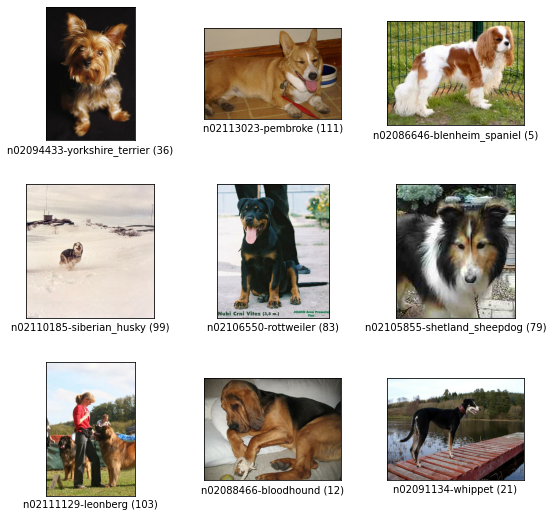

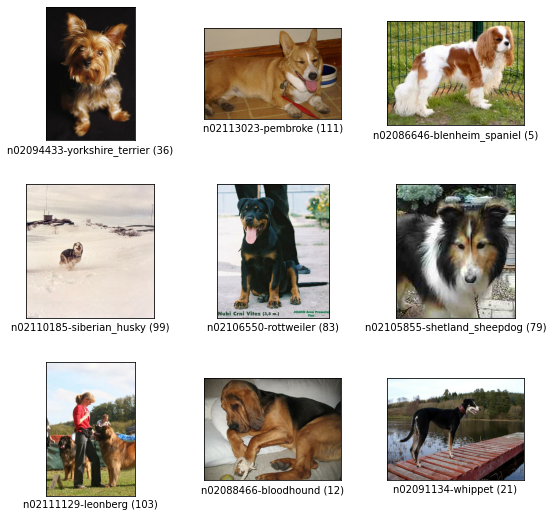

In [4]:
# 데이터가 제대로 들어왔는지 확인
tfds.show_examples(train_data, data_info)

### 데이터 전처리+augmentation
관련 함수는 문제에 제시된대로 사용

In [5]:
# stanford_dogs의 class개수 확인
num_classes= data_info.features["label"].num_classes
num_classes

120

In [6]:
# 이미지를 224*224로 만들고 image tensor의 각 데이터를 0~1사이 값으로 정규화시키는 함수
def normalize_and_resize_img(image, label):
    image= tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32)/ 255., label

In [7]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [8]:
def onehot(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), num_classes)
    return image, label

In [9]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box, 균등분포 함수, []크기의, 0~image_size_x인 int32값 출력
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box, 0~1사이의 값을 제곱근한 값(비율값)을 이미지의 x축 크기에 곱한 뒤, 
    # int32로 만든다.(cast 과정에서 소수점 제거)
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [10]:
# 두 이미지를 cutmix하는 작업
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [11]:
# 두 이미지의 레이블을 지정하는 작업 (cutmix)
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [12]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))
        



    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [13]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [14]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    print(ds)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [16]:
# 각 데이터별 설정 no aug, 기본 aug, 기본+cutmix, 기본+mixup
train_data_no_aug = apply_normalize_on_dataset(train_data, with_aug=False)
train_data_aug = apply_normalize_on_dataset(train_data, with_aug=True)
train_data_aug_cutmix= apply_normalize_on_dataset(train_data, with_aug=True, with_cutmix=True)
train_data_aug_mixup= apply_normalize_on_dataset(train_data, with_aug=True, with_mixup=True)
test_data = apply_normalize_on_dataset(test_data, is_test=True)

<ParallelMapDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>


## 2. 모델 설계 및 훈련
### 모델 설계
resnet50 사용 No augmentation, 기본 Augmentation, 기본+CutMix, 기본+Mixup 순으로 설계하였다.

In [17]:
# No augmentation
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [18]:
# 기본 augmentation
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
# 기본+cutmix augmentation
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
# 기본+mixup augmentation
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
EPOCH = 20
# EPOCH = 10

In [22]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    train_data_no_aug, 
    steps_per_epoch=int(data_info.splits['train'].num_examples/16),
    validation_steps=int(data_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=test_data,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 194s 201ms/step - loss: 2.2096 - accuracy: 0.4411 - val_loss: 3.2308 - val_accuracy: 0.2315
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.7080 - accuracy: 0.8071 - val_loss: 1.2845 - val_accuracy: 0.6402
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2190 - accuracy: 0.9546 - val_loss: 0.9713 - val_accuracy: 0.7158
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0664 - accuracy: 0.9947 - val_loss: 0.9177 - val_accuracy: 0.7372
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0271 - accuracy: 0.9993 - val_loss: 0.9156 - val_accuracy: 0.7416
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0181 - accuracy: 0.9996 - val_loss: 0.9483 - val_accuracy: 0.7336
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0139 - accuracy: 0.9995 - val_loss: 0.9440 -

In [23]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50 = aug_resnet50.fit(
    train_data_aug, 
    steps_per_epoch=int(data_info.splits['train'].num_examples/16),
    validation_steps=int(data_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=test_data,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 208ms/step - loss: 2.2586 - accuracy: 0.4358 - val_loss: 3.3119 - val_accuracy: 0.2181
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.9246 - accuracy: 0.7335 - val_loss: 1.2098 - val_accuracy: 0.6425
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.4979 - accuracy: 0.8626 - val_loss: 1.1108 - val_accuracy: 0.6781
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2609 - accuracy: 0.9383 - val_loss: 1.2347 - val_accuracy: 0.6528
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1415 - accuracy: 0.9733 - val_loss: 0.9949 - val_accuracy: 0.7213
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0833 - accuracy: 0.9871 - val_loss: 1.0713 - val_accuracy: 0.7065
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0552 - accuracy: 0.9919 - val_loss: 1.1115 -

In [24]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_cutmix_resnet50 = aug_cutmix_resnet50.fit(
    train_data_aug_cutmix, 
    steps_per_epoch=int(data_info.splits['train'].num_examples/16),
    validation_steps=int(data_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=test_data,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 209ms/step - loss: 3.9018 - accuracy: 0.1960 - val_loss: 3.7670 - val_accuracy: 0.1641
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 3.0410 - accuracy: 0.4058 - val_loss: 1.4467 - val_accuracy: 0.6101
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 2.7829 - accuracy: 0.4871 - val_loss: 1.6681 - val_accuracy: 0.5430
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 2.5723 - accuracy: 0.5462 - val_loss: 1.1741 - val_accuracy: 0.6740
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 2.4524 - accuracy: 0.5878 - val_loss: 1.3164 - val_accuracy: 0.6397
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 2.3478 - accuracy: 0.6210 - val_loss: 1.2121 - val_accuracy: 0.6774
Epoch 7/20
750/750 [==============================] - 156s 209ms/step - loss: 2.2502 - accuracy: 0.6530 - val_loss: 1.3078 -

In [25]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_mixup_resnet50 = aug_mixup_resnet50.fit(
    train_data_aug_mixup, 
    steps_per_epoch=int(data_info.splits['train'].num_examples/16),
    validation_steps=int(data_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=test_data,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 210ms/step - loss: 3.7757 - accuracy: 0.2249 - val_loss: 3.4895 - val_accuracy: 0.1947
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 2.9573 - accuracy: 0.4397 - val_loss: 1.7252 - val_accuracy: 0.5349
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.6632 - accuracy: 0.5418 - val_loss: 1.3773 - val_accuracy: 0.6073
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 2.5140 - accuracy: 0.6042 - val_loss: 1.3745 - val_accuracy: 0.6115
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3827 - accuracy: 0.6519 - val_loss: 1.2770 - val_accuracy: 0.6378
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 2.2690 - accuracy: 0.6932 - val_loss: 1.2318 - val_accuracy: 0.6536
Epoch 7/20
750/750 [==============================] - 156s 209ms/step - loss: 2.2008 - accuracy: 0.7229 - val_loss: 1.1551 -

### 훈련 결과 시각화

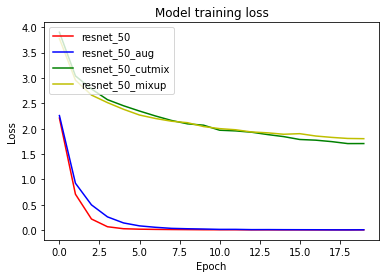

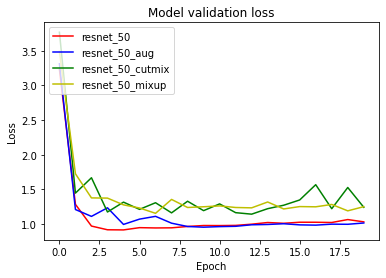

In [32]:
import matplotlib.pyplot as plt

# plt.subplot(211)
plt.figure(1)
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_aug_resnet50.history['loss'], 'b')
plt.plot(history_aug_cutmix_resnet50.history['loss'], 'g')
plt.plot(history_aug_mixup_resnet50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_aug', 'resnet_50_cutmix', 'resnet_50_mixup'], loc='upper left')

# plt.subplot(212)
plt.figure(2)
plt.plot(history_resnet50.history['val_loss'], 'r')
plt.plot(history_aug_resnet50.history['val_loss'], 'b')
plt.plot(history_aug_cutmix_resnet50.history['val_loss'], 'g')
plt.plot(history_aug_mixup_resnet50.history['val_loss'], 'y')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_aug', 'resnet_50_cutmix', 'resnet_50_mixup'], loc='upper left')
plt.show()

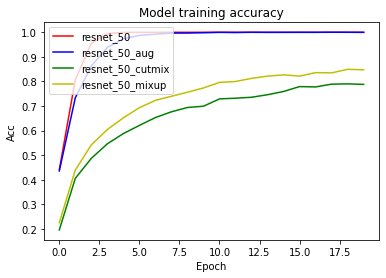

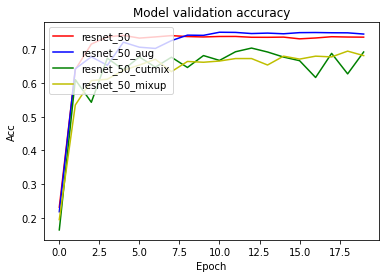

In [33]:
# plt.subplot(211)
plt.figure(1)
plt.plot(history_resnet50.history['accuracy'], 'r')
plt.plot(history_aug_resnet50.history['accuracy'], 'b')
plt.plot(history_aug_cutmix_resnet50.history['accuracy'], 'g')
plt.plot(history_aug_mixup_resnet50.history['accuracy'], 'y')
plt.title('Model training accuracy')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_aug', 'resnet_50_cutmix', 'resnet_50_mixup'], loc='upper left')

# plt.subplot(212)
plt.figure(2)
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_aug_cutmix_resnet50.history['val_accuracy'], 'g')
plt.plot(history_aug_mixup_resnet50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_aug', 'resnet_50_cutmix', 'resnet_50_mixup'], loc='upper left')
plt.show()

### 훈련 결과 비교 및 회고
augmentation 결과, 의외로 augmentation을 거치지 않은 resnet이 가장 좋은 성능을 보였고, 그 뒤를 기본 augmentation, mixup, cutmix가 차지했다. 과제의 주제가 augmentation이었기 때문에 'augmentation을 하면 더 좋은 성능을 낼꺼야'라는 고정관념을 보기 좋게 부숴버린 것이다. 또한 기본 augmentation이 cutmix나 mixup보다 좋은 성능을 보여줬는데, 기본 augmentation은 가로와 세로를 바꾸는 filp과 brightness만 조정해 주었기 때문에 다른 augmentation에 비해 원본 데이터와 유사하다는 점을 고려했을 때 실질적으로는 stanford dogs 데이터셋에 대해서는 augmentation을 하지 않는 편이 더 우수한 성능을 가진다는 결론을 내릴 수 있었다.  
  
이번 과제를 진행하면 좋았던 점은 조금씩 데이터를 다루는 방식이 정형화되는 것을 느꼈다는 것이다. 물론 코딩을 기계적으로 하는 것이 좋을 리는 없지만 지나치게 간단하지만 모르는 것들을 하나하나 익히고 있다. one-hot encoding시 label형 변환이 필요한 수 있다든지, 레이블과 모델의 최종 output이 맞지 않을 때 어떤 에러가 발생한다든지, dataset 객체의 map함수에 익숙해진다든지 하는 것들은 간단한 문제들이지만 어디서나 활용될 수 있는 지식들이고, 이런 것들은 어느 정도 기계적으로 알고 처리할 수 있을 때, 더 고등한 문제들을 해결할 수 있기 때문이다. 그래서 augmentation보다 그런 부분이 만족스러웠다.